# DBSCAN EXERCISE

Group members:
- Ginevra Beltrame;
- Emanuele Coradin;
- Ada D'Iorio;
- Dario Liotta.

## Libraries

In [1]:
%matplotlib inline

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import seaborn as sns
import pandas as pd
from matplotlib.cm import ScalarMappable
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import itertools
from sklearn.decomposition import PCA

# Lecture

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N =",N,"  L=D=",D)
x=data

print(data)

N = 600   L=D= 12
[[  61.27759991  131.11971044 -101.38286051 ... -133.12981604
    30.99825086  -63.16979905]
 [ 244.6283114  -343.34006186  171.12362908 ... -129.51652869
   139.87558252 -128.06711208]
 [ 190.93410636 -370.40817484  235.5403426  ...  120.66610566
  -105.02441519   71.46921625]
 ...
 [ -58.74811627 -176.36409297   77.60891688 ...  112.15762092
  -167.11089778  108.09672504]
 [-145.26216672  451.9135936  -211.13150802 ... -311.54416287
   -68.25854801   15.12029522]
 [  20.59719086 -363.17153946  182.54425886 ...  446.42114532
    66.32431109  153.31599752]]


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

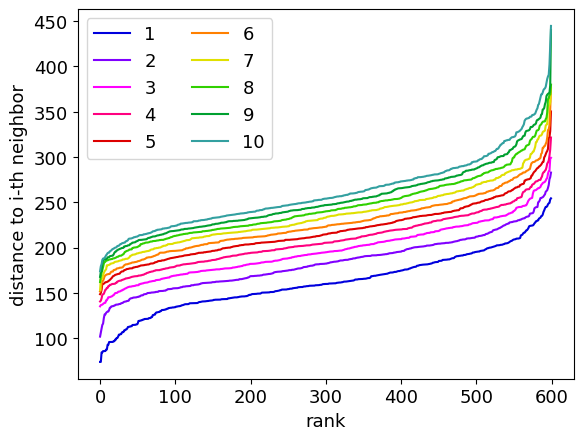

mean minimum distance between points: 162.35
maximum distance between closest points: 254.30


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print(f"mean minimum distance between points: {mean_min_dist:.2f}")
print(f"maximum distance between closest points: {np.max(dd[1]):.2f}")

## t-SNE visualization, for true labels

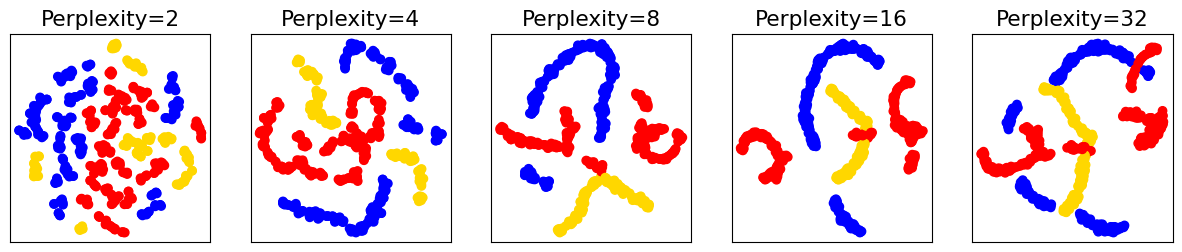

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold"])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

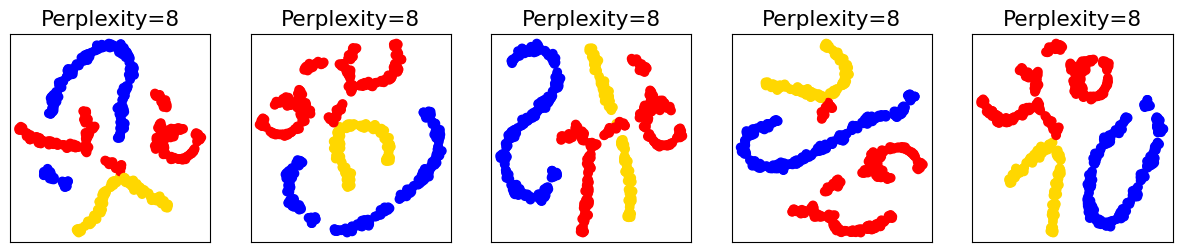

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

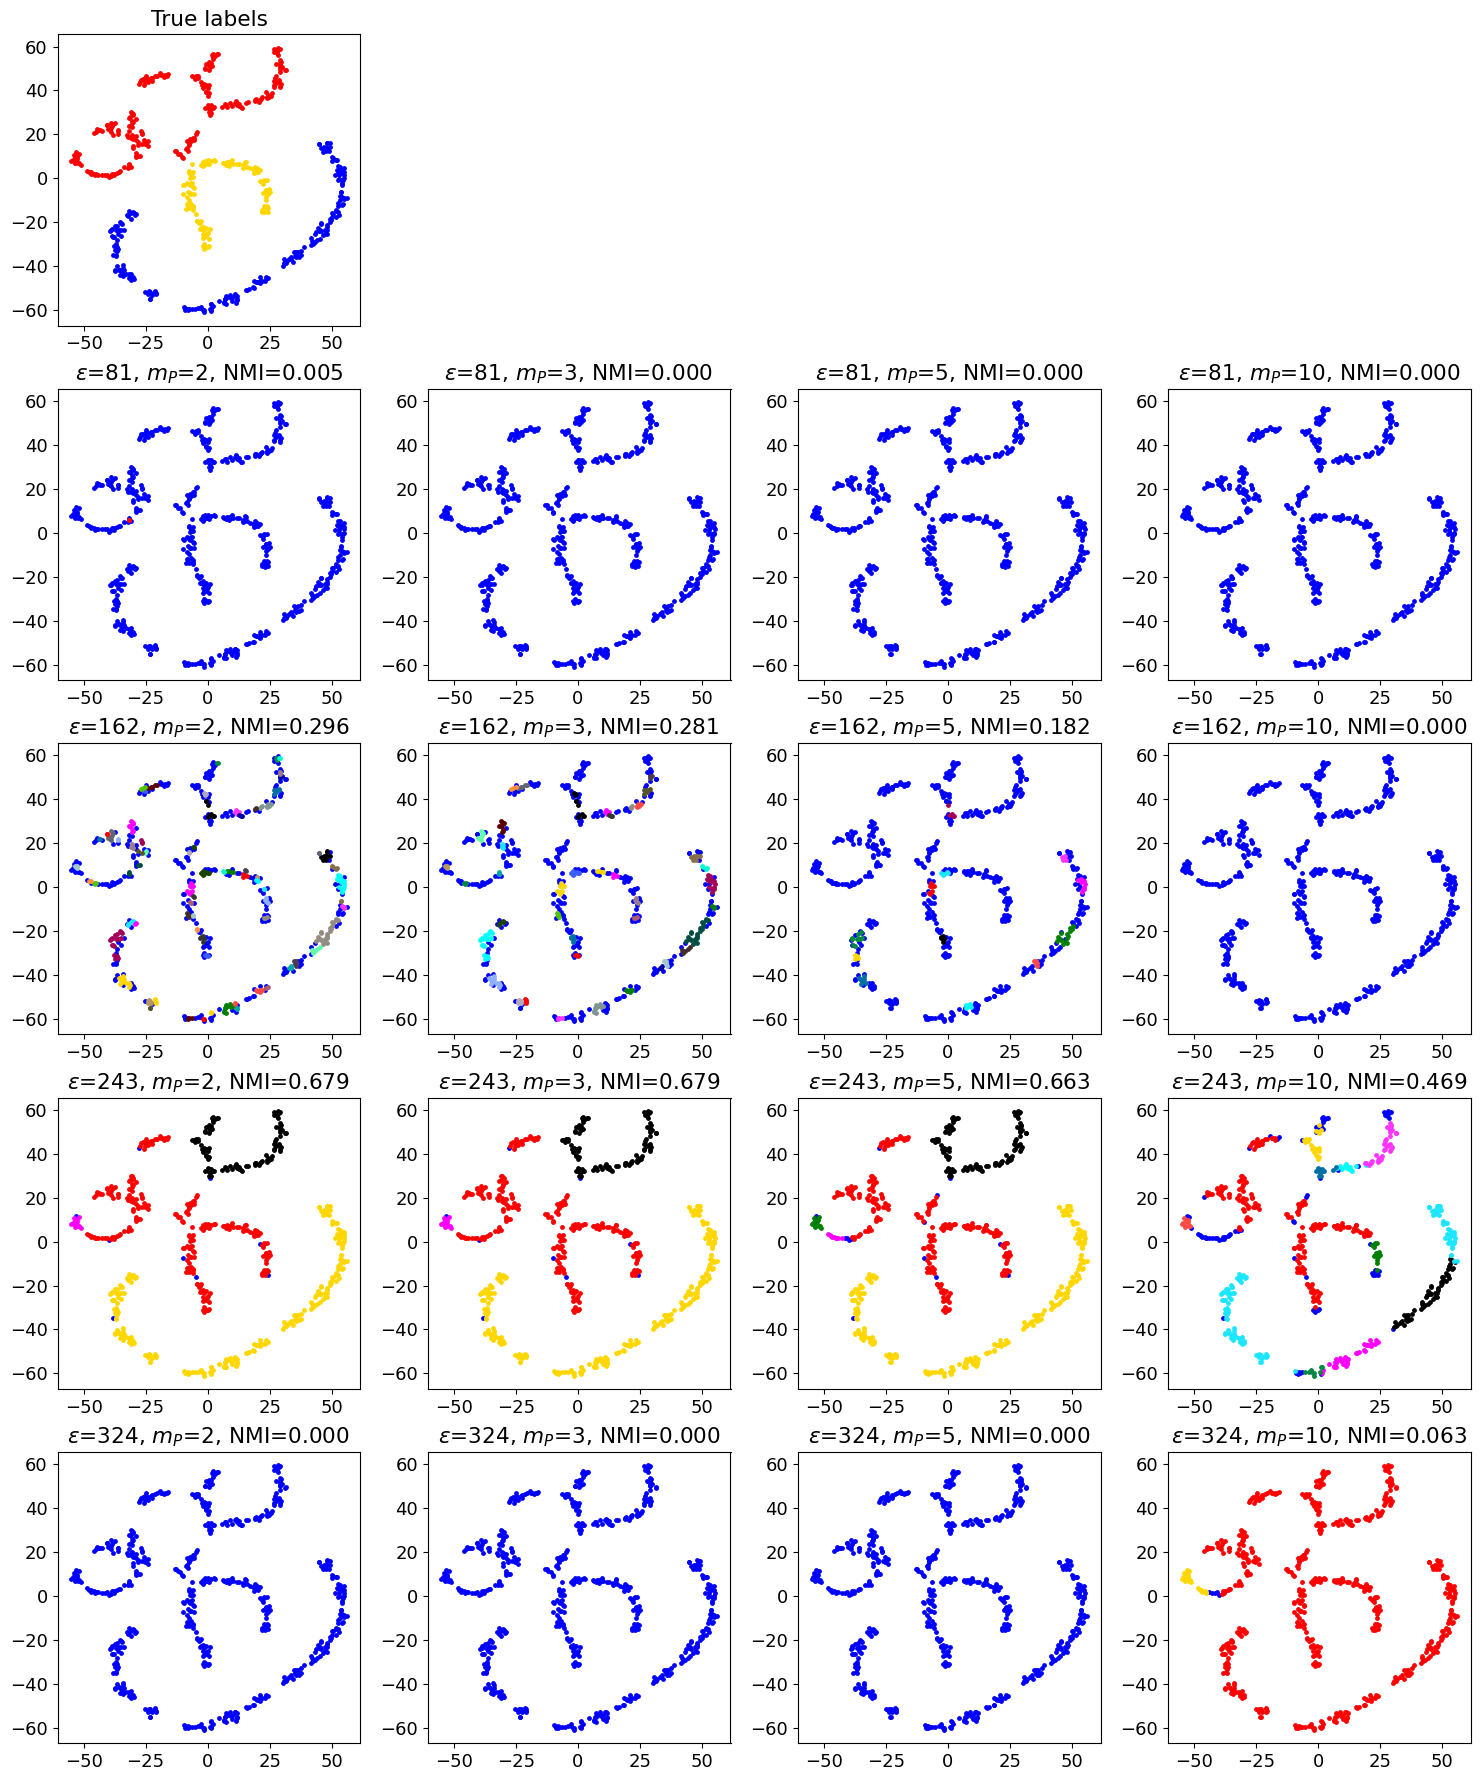

In [6]:
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(15,18))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()


# Exercise

### Section 1

In [7]:
eps_range = np.arange(10, 400, 10)
min_sample_range = np.arange(1,50,1)
list_NMI = []

for eps in eps_range:
    for min_samples in min_sample_range:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(data)
        y_hat = model.labels_
        list_NMI.append(NMI(y_hat, y_true))

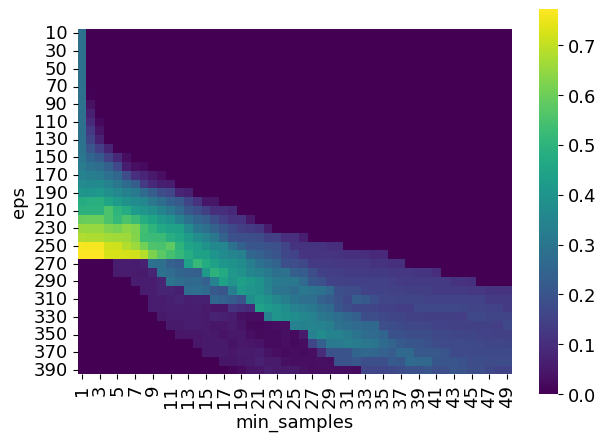

In [8]:
NMIs = pd.DataFrame(np.array(list_NMI).reshape(np.shape(eps_range)[0], np.shape(min_sample_range)[0]), index=eps_range, columns=min_sample_range)

fig = plt.figure(figsize=(7,5))
sns.heatmap(NMIs, cmap='viridis', xticklabels=2, yticklabels=2, square=True)
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

We observe a linear-like correlation between $\epsilon$ and $m_p$ , which is what we expected from the theory of DBSCAN. With the increasing of the minimum number of neighbours, the radius of the sphere decreases. As it can be observed from the graph of $m_p$ as a function of the rank (Lecture section), there is a threshold value for epsilon between 200 and 300. So for a smaller $\epsilon$ no clustering is possible.

### Section 2

We first plot the covariance matrix to observe the correlation between the coordinates.

In [9]:
pca_object = PCA(n_components=np.shape(data)[1])

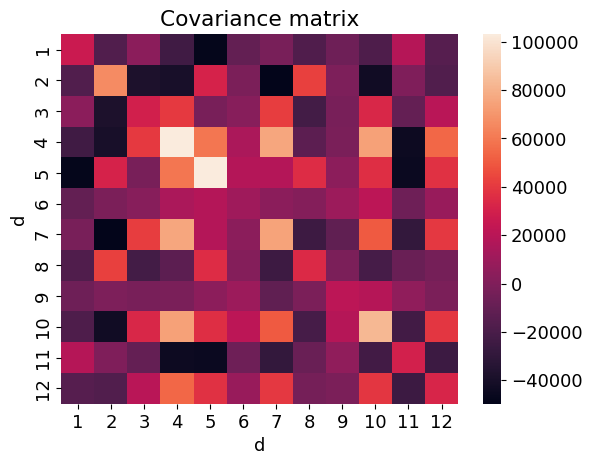

In [10]:
covariance_matrix = pca_object.fit(data).get_covariance()
C = pd.DataFrame(covariance_matrix, index=np.arange(1,13,1), columns=np.arange(1,13,1))
sns.heatmap(C)
plt.xlabel('d')
plt.ylabel('d')
plt.title('Covariance matrix')
plt.show()

In order to perform the PCA we first compute the percentage contribution of each eigenvalue.

In [11]:
frac_x1, frac_x2, frac_x3, frac_x4 = pca_object.explained_variance_ratio_[0]*100, pca_object.explained_variance_ratio_[1]*100, pca_object.explained_variance_ratio_[2]*100, pca_object.explained_variance_ratio_[3]*100 

print('------------ Percentage contribution of different eigenvalues to the variance: ------------')
print(" l1: %.2f" % frac_x1, '% \n', "l2: %.2f" % frac_x2, '% \n', "l3: %.2f" % frac_x3, '% \n', "l4: %.2f" % frac_x4, '%')
print(f'Total variability explained by the first 3 PCs: {frac_x1 + frac_x2 + frac_x3 :.2f}', '%')

------------ Percentage contribution of different eigenvalues to the variance: ------------
 l1: 56.09 % 
 l2: 30.91 % 
 l3: 9.28 % 
 l4: 0.51 %
Total variability explained by the first 3 PCs: 96.28 %


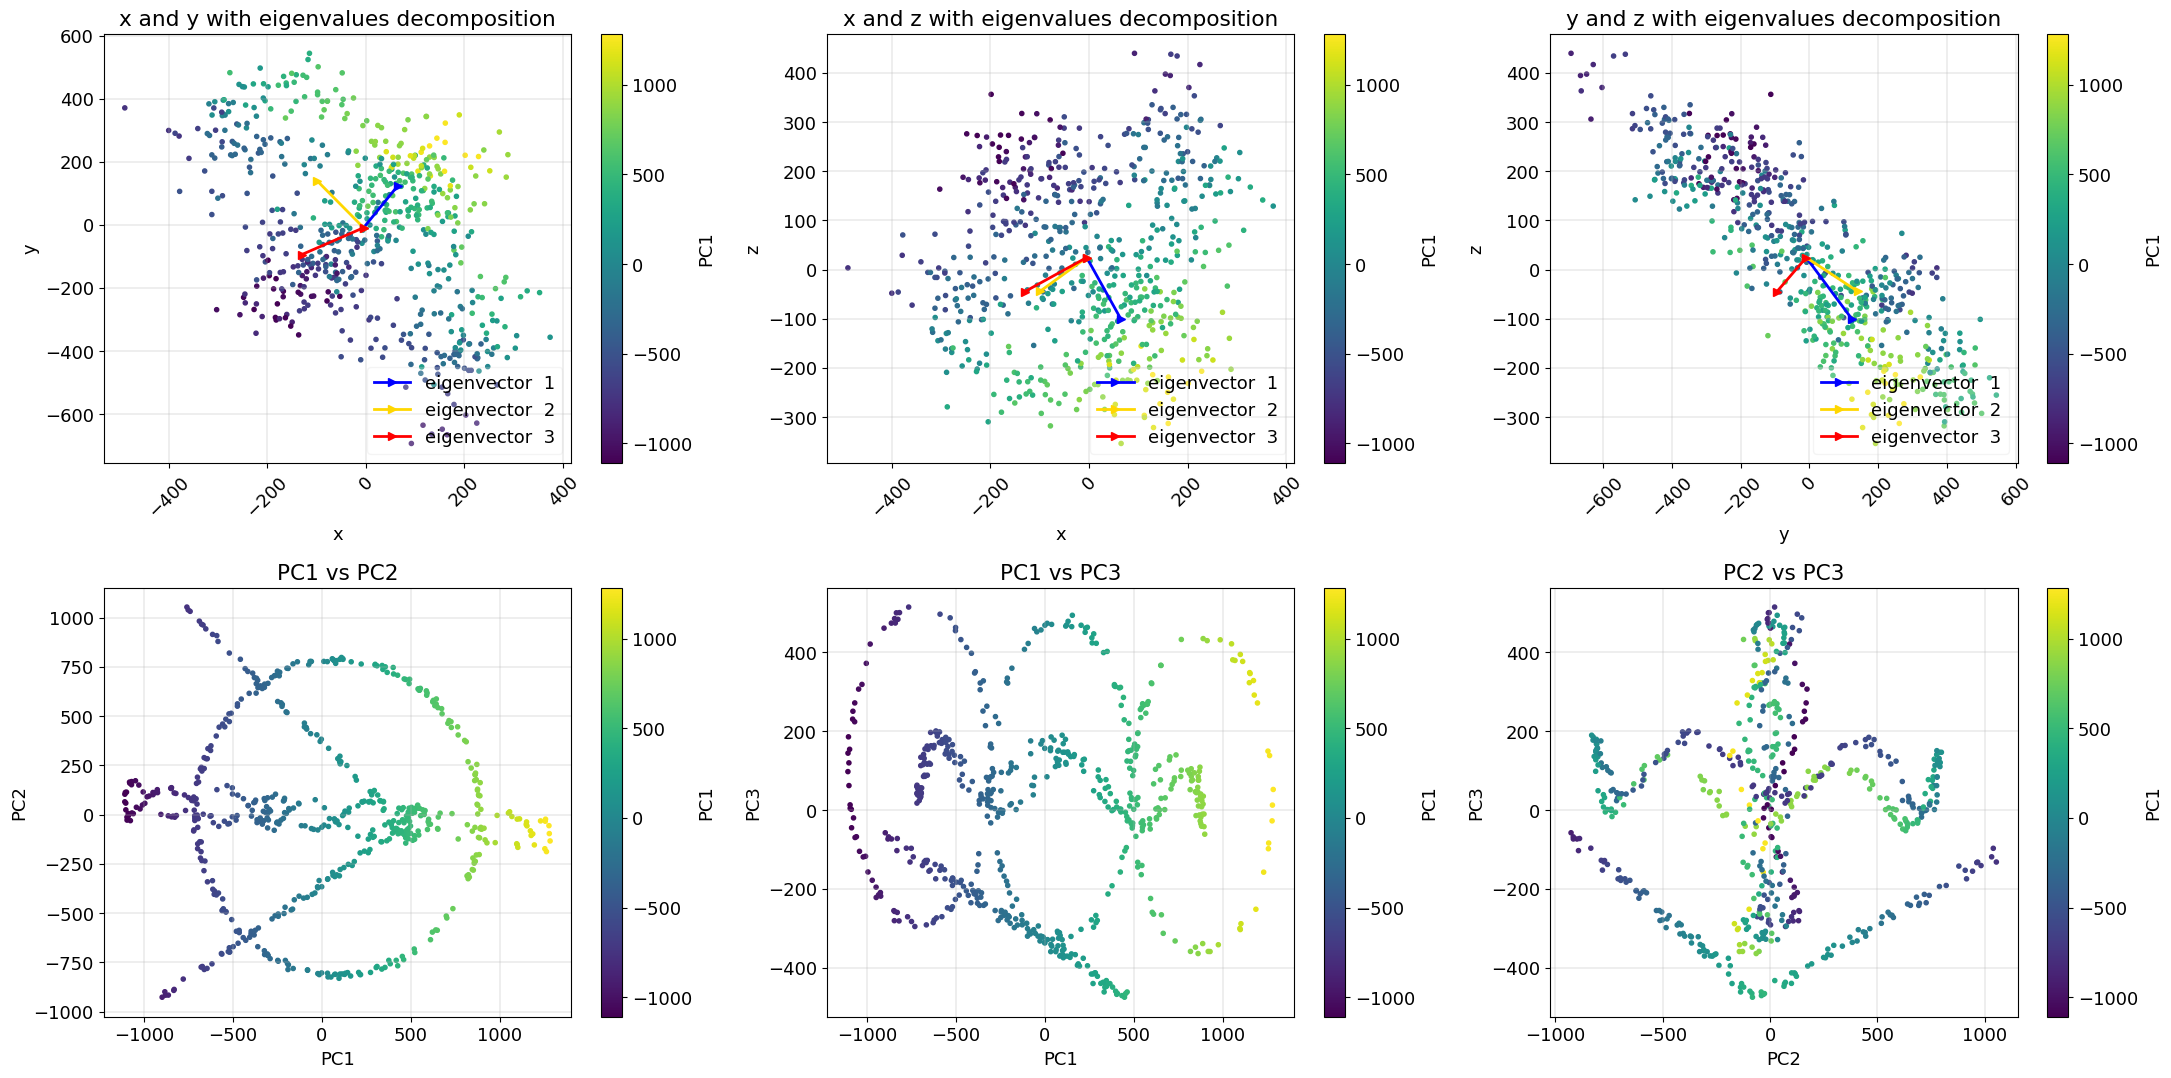

In [12]:
Xp = pca_object.fit_transform(data).T
x1,x2,x3 = x[:,0], x[:,1], x[:,2]
mean_x1 = np.mean(x1)
mean_x2 = np.mean(x2)
mean_x3 = np.mean(x3)
normalized_l = pca_object.explained_variance_ratio_[:3]
V = pca_object.components_[:3]

colors = ['blue', 'gold', 'red']
scale_factor = [1000,1000,10000]

plt.figure(figsize=(22,16))

### PLOT 1 ###

plt.subplot(331)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(x1, x2, c = Xp[0,:], marker = '.', cmap = cmap, norm = norm)
plt.xticks(rotation=45)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

counter = 1
for li, vi, si, ci in zip(normalized_l, V, scale_factor, colors):
    plt.plot([mean_x1, si*li*vi[0]+mean_x1], [mean_x2, si*li*vi[1]+mean_x2], ci, lw = 2, marker='>', label = 'eigenvector  ' + str(counter))
    counter += 1

plt.title('x and y with eigenvalues decomposition')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, linewidth=0.3)
legend = plt.legend(loc='lower right')
legend.get_frame().set_alpha(0.2)

### PLOT 2 ###

plt.subplot(332)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(x1, x3, c = Xp[0,:], marker = '.', cmap = cmap, norm = norm)
plt.xticks(rotation=45)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

counter = 1
for li, vi, si, ci in zip(normalized_l, V, scale_factor, colors):
    plt.plot([mean_x1, si*li*vi[0]+mean_x1], [mean_x3, si*li*vi[2]+mean_x3], ci, lw = 2, marker='>', label = 'eigenvector  ' + str(counter)) #proiezione degli autovettori nel piano (x, z)
    counter += 1

plt.title('x and z with eigenvalues decomposition')
plt.xlabel('x')
plt.ylabel('z')
plt.grid(True, linewidth=0.3)
legend = plt.legend(loc='lower right')
legend.get_frame().set_alpha(0.2)

### PLOT 3 ###

plt.subplot(333)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(x2, x3, c = Xp[0,:], marker = '.', cmap = cmap, norm = norm)
plt.xticks(rotation=45)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

counter = 1
for li, vi, si, ci in zip(normalized_l, V, scale_factor, colors):
    plt.plot([mean_x2, si*li*vi[1]+mean_x2], [mean_x3, si*li*vi[2]+mean_x3], ci, lw = 2, marker='>', label = 'eigenvector  ' + str(counter)) #proiezione degli autovettori nel piano (y, z)
    counter += 1

plt.title('y and z with eigenvalues decomposition')
plt.xlabel('y')
plt.ylabel('z')
plt.grid(True, linewidth=0.3)
legend = plt.legend(loc='lower right')
legend.get_frame().set_alpha(0.2)

### PLOT 4 ###

plt.subplot(334)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(Xp[0,:], Xp[1,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')

plt.title('PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linewidth=0.3)

### PLOT 5 ###

plt.subplot(335)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(Xp[0,:], Xp[2,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')
plt.title('PC1 vs PC3')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)

### PLOT 6 ###

plt.subplot(336)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.scatter(Xp[1,:], Xp[2,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('PC1')
plt.title('PC2 vs PC3')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

The PCA helps in the visualization of the dataset because it removes the background noise, mostly present in the dimensions we discarded. In this way it is possible to recognize a well defined structure in the dataand choose the best method to perform the clustering.

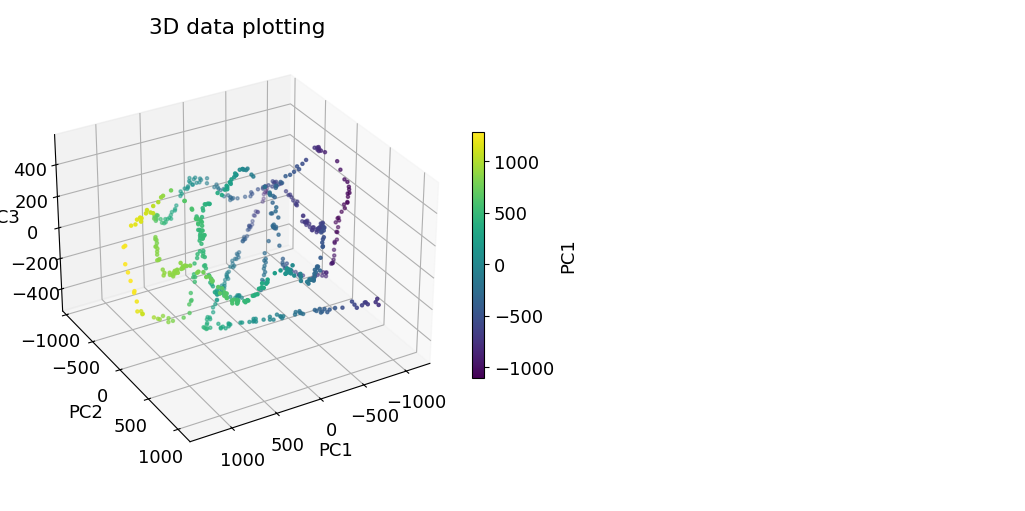

In [13]:
fig = plt.figure(figsize=(10,5), layout='constrained')
ax = fig.add_subplot(1,2,1,projection='3d')

ax.scatter(Xp[0,:], Xp[1,:], Xp[2,:], marker = '.', c = Xp[0,:], cmap = cmap, norm = norm)
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.5, pad=0.05)
cbar.set_label('PC1')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(30,60)
plt.title('3D data plotting')

ax_legend = fig.add_subplot(1,2,2)
ax_legend.axis('off')

plt.show()

We retry the DBSCAN algorithm in this lower-dimensional space. The result is similar to the previous case, confirming our reasoning. 

In [14]:
eps_range = np.arange(10, 400, 10)
min_sample_range = np.arange(1,50,1)
list_NMI = []

for eps in eps_range:
    for min_samples in min_sample_range:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(Xp.T)
        y_hat = model.labels_
        list_NMI.append(NMI(y_hat, y_true))

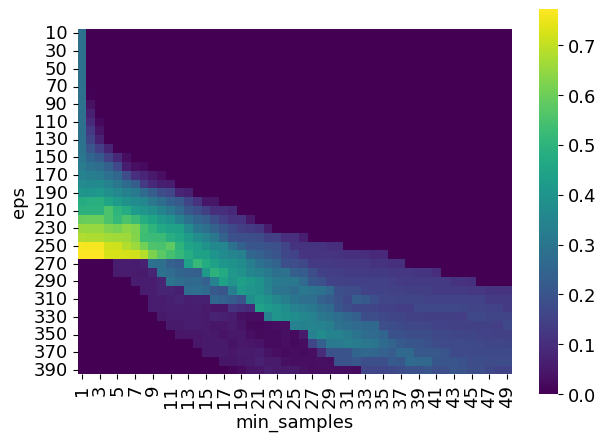

In [15]:
NMIs = pd.DataFrame(np.array(list_NMI).reshape(np.shape(eps_range)[0], np.shape(min_sample_range)[0]), index=eps_range, columns=min_sample_range)

fig = plt.figure(figsize=(7,5))
sns.heatmap(NMIs, cmap='viridis', xticklabels=2, yticklabels=2, square=True)
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

In [16]:
print(f"The best NMI is: {max(list_NMI):.2f}")

The best NMI is: 0.77


### Section 3

#### Kmeans analysis

In [17]:
k=3

kmeans = KMeans(n_clusters=k, init='random', n_init='auto', max_iter=50)
kfit = kmeans.fit(Xp.T)
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_
kcentroids_colors = ['firebrick', 'darkkhaki', 'darkblue']
kclusters_colors = []

for i,k  in enumerate(kclusters):
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('gold')
    elif k == 2:
        kclusters_colors.append('blue')

yclusters_colors = []

for i,k  in enumerate(y):
    if k == 0:
        yclusters_colors.append('red')
    elif k == 1:
        yclusters_colors.append('gold')
    elif k == 2:
        yclusters_colors.append('blue')

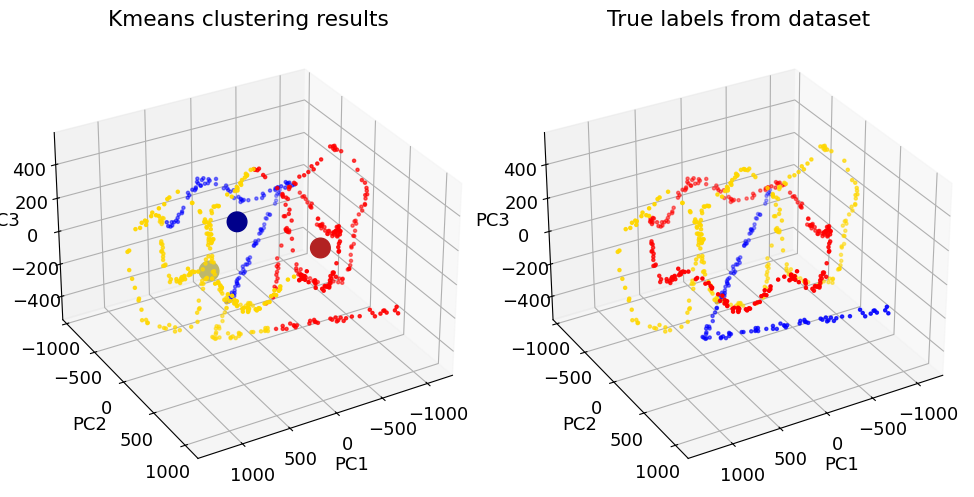

In [18]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1,projection='3d')

ax1.set_title('Kmeans clustering results')
ax1.scatter(Xp[0,:], Xp[1,:], Xp[2,:], marker = '.', color = kclusters_colors)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.view_init(30,60)
kcentroids = kcentroids[:3, :3]
ax1.scatter(kcentroids[:, 0], kcentroids[:,1], kcentroids[:,2], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.set_title('True labels from dataset')
ax2.scatter(Xp[0,:], Xp[1,:], Xp[2,:], marker = '.', color = yclusters_colors)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.view_init(30,60)

plt.tight_layout()
plt.show()

In [19]:
print(f"The NMI of Kmeans is: {NMI(kclusters, y_true):.2f}")

The NMI of Kmeans is: 0.13


We plotted the data clustering obtained by the Kmeans approach on the left, with the relative centroids, and the data clustered according to the provided true labels on the right. We observe that the data is not suitable to be analyzed with the Kmeans approach, as the Euclidean distance function is not a good way to compute clustering relationships in this case.

From the observation of the true labels' plot, it can be noted that by transforming the feature space with some appropriate nonlinear mapping, a better performance may be achieved. For instance, the red cluster points are approximately equidistant from the origin of the PC space, so by considering the 3D norm of the corresponding vectors as an additional feature, these points would all have very similar values. The cluster could therefore be better identified by the Kmeans, although the same mapping wouldn't be as effective for clustering the yellow and blue sets.

In order to explore what data dimensionality reduction is the most effective to obtain clustering, we repeated the analysis considering only the first two PCs.

In [20]:
pca_object = PCA(n_components=2)
Xp = pca_object.fit_transform(data)

In [21]:
nclusters=3

kmeans = KMeans(n_clusters=nclusters, init='random', n_init='auto', max_iter=50)
kfit = kmeans.fit(Xp)
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_
kclusters_colors = []

for i,k  in enumerate(kclusters):
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('gold')
    elif k == 2:
        kclusters_colors.append('blue')
print(f"The NMI of Kmeans in 2 dimensions is: {NMI(kclusters, y_true):.2f}")

The NMI of Kmeans in 2 dimensions is: 0.10


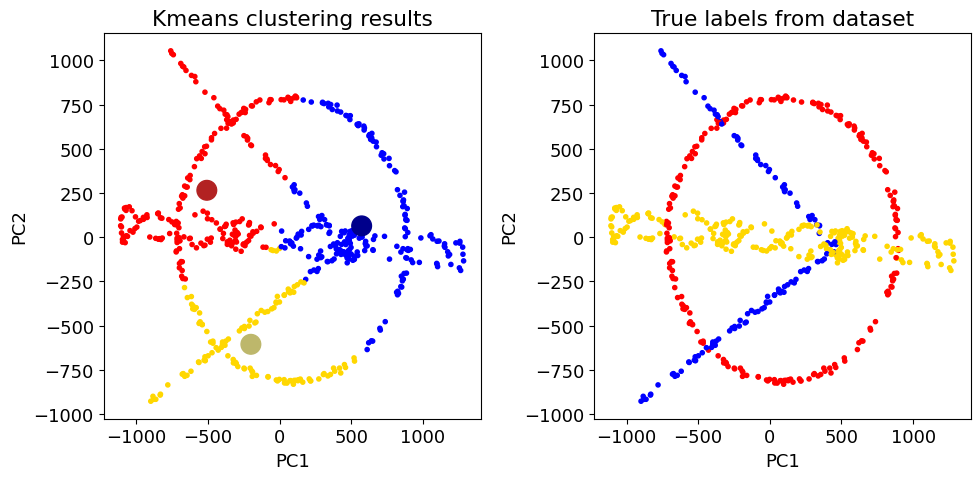

In [22]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)

ax1.set_title('Kmeans clustering results')
ax1.scatter(Xp[:,0], Xp[:,1], marker = '.', color = kclusters_colors)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
kcentroids = kcentroids[:3, :2]
kcentroids_colors = ['firebrick', 'darkkhaki', 'darkblue']
ax1.scatter(kcentroids[:, 0], kcentroids[:,1], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

ax2 = fig.add_subplot(1,2,2)

ax2.set_title('True labels from dataset')
ax2.scatter(Xp[:,0], Xp[:,1], marker = '.', color = yclusters_colors)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.tight_layout()
plt.show()

We can conclude that the in 2D the data is as unsuitable for K-Means clustering as in 3D, so we decide to keep the most informative of the two sets. We visualize 3D data once more by plotting the corresponding 2D projections and we compare once again Kmeans labels and true labels. 

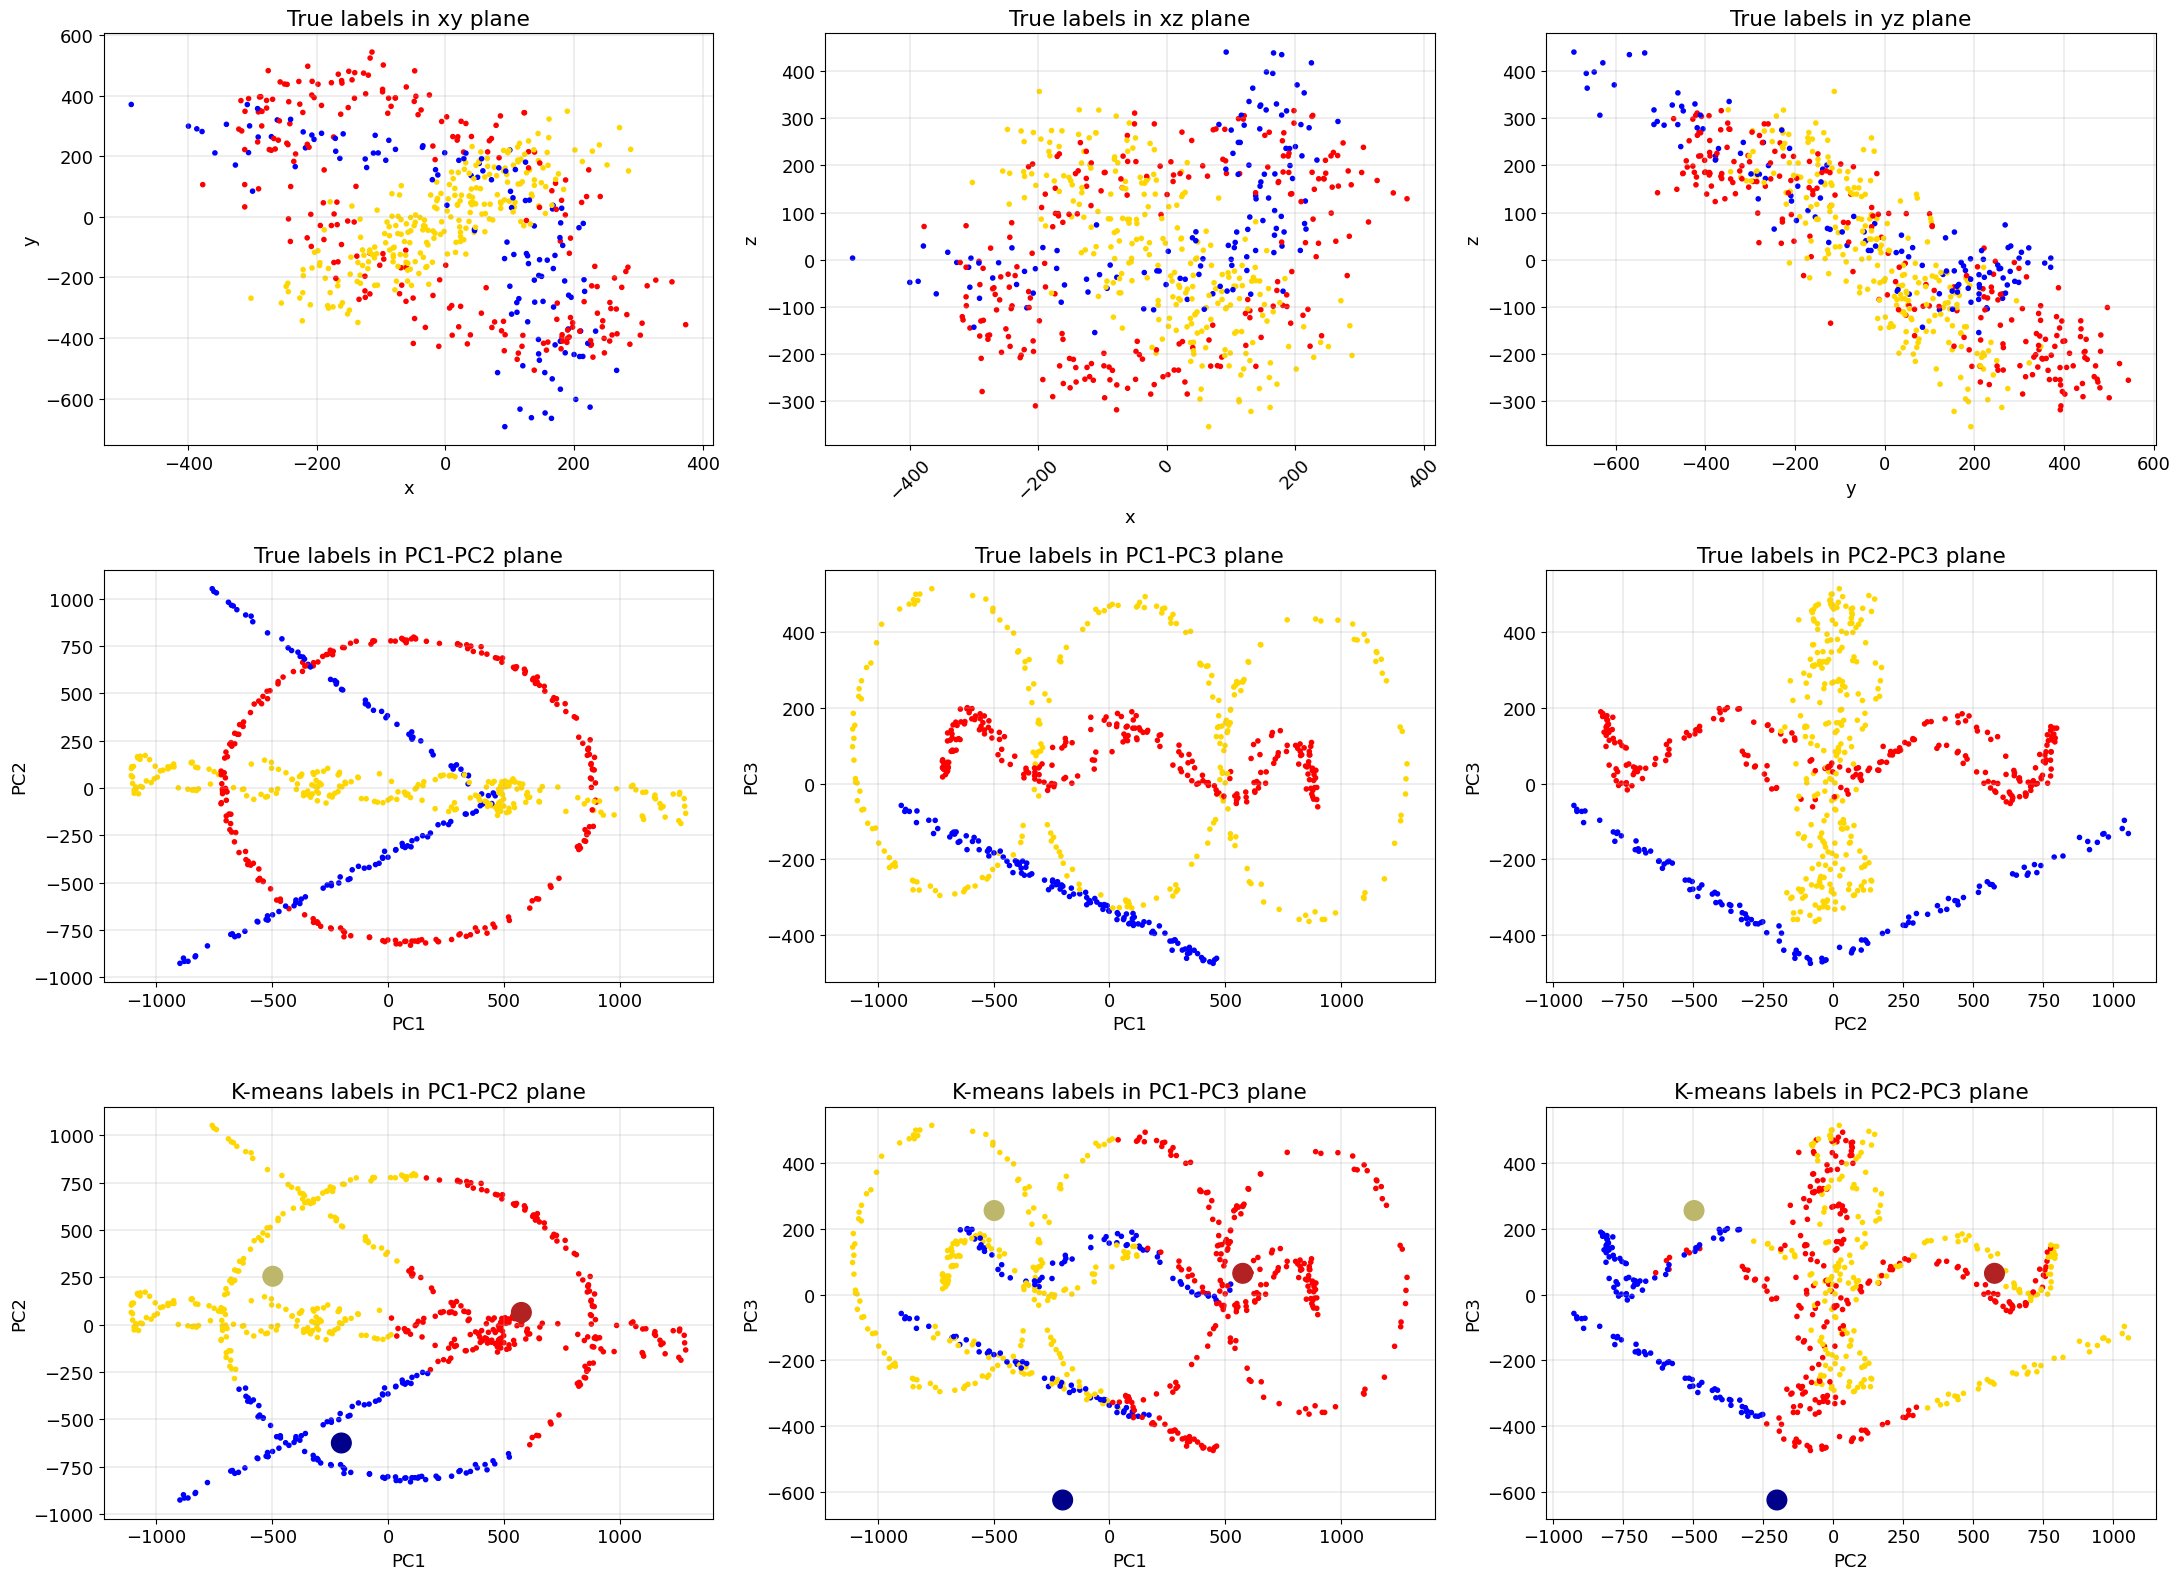

In [23]:
pca_object = PCA(n_components=3)
Xp = pca_object.fit_transform(data).T

k=3

kmeans = KMeans(n_clusters=k, init='random', n_init='auto', max_iter=50)
kfit = kmeans.fit(Xp.T)
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_
kcentroids_colors = ['firebrick', 'darkkhaki', 'darkblue']
kclusters_colors = []

for i,k  in enumerate(kclusters):
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('gold')
    elif k == 2:
        kclusters_colors.append('blue')

yclusters_colors = []

for i,k  in enumerate(y):
    if k == 0:
        yclusters_colors.append('red')
    elif k == 1:
        yclusters_colors.append('gold')
    elif k == 2:
        yclusters_colors.append('blue')

plt.figure(figsize=(22,16))

### PLOT 1 ###

plt.subplot(331)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
plt.scatter(x1, x2, color = yclusters_colors, marker = '.') 

plt.title('True labels in xy plane')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, linewidth=0.3)

### PLOT 2 ###

plt.subplot(332)

norm = plt.Normalize(Xp[0,:].min(), Xp[0,:].max())
plt.scatter(x1, x3, color = yclusters_colors, marker = '.')
plt.xticks(rotation=45)

plt.title('True labels in xz plane')
plt.xlabel('x')
plt.ylabel('z')
plt.grid(True, linewidth=0.3)

### PLOT 3 ###

plt.subplot(333)

plt.scatter(x2, x3, color = yclusters_colors , marker = '.')
plt.title('True labels in yz plane')
plt.xlabel('y')
plt.ylabel('z')
plt.grid(True, linewidth=0.3)

### PLOT 4 ###

plt.subplot(334)

plt.scatter(Xp[0,:], Xp[1,:], marker = '.',color = yclusters_colors)
plt.title('True labels in PC1-PC2 plane')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linewidth=0.3)

### PLOT 5 ###

plt.subplot(335)

plt.scatter(Xp[0,:], Xp[2,:], marker = '.', color = yclusters_colors)
plt.title('True labels in PC1-PC3 plane')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)

### PLOT 6 ###

plt.subplot(336)

plt.scatter(Xp[1,:], Xp[2,:], marker = '.', color = yclusters_colors)
plt.title('True labels in PC2-PC3 plane')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)

### PLOT 7 ###

plt.subplot(337)

plt.scatter(Xp[0,:], Xp[1,:], marker = '.', color = kclusters_colors)
plt.title('K-means labels in PC1-PC2 plane')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linewidth=0.3)
plt.scatter(kcentroids[:, 0], kcentroids[:,1], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

### PLOT 8 ###

plt.subplot(338)

plt.scatter(Xp[0,:], Xp[2,:], marker = '.', color = kclusters_colors)
plt.title('K-means labels in PC1-PC3 plane')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)
plt.scatter(kcentroids[:, 0], kcentroids[:,1], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

### PLOT 9 ###

plt.subplot(339)

plt.scatter(Xp[1,:], Xp[2,:], marker = '.', color = kclusters_colors)
plt.title('K-means labels in PC2-PC3 plane')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True, linewidth=0.3)
plt.scatter(kcentroids[:, 0], kcentroids[:,1], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

plt.tight_layout()
plt.show()

#### Hierarchical Clustering analysis

For this analysis we chose the four methods of the `linkage` function thet we considered to be the most suitable for the dataset.

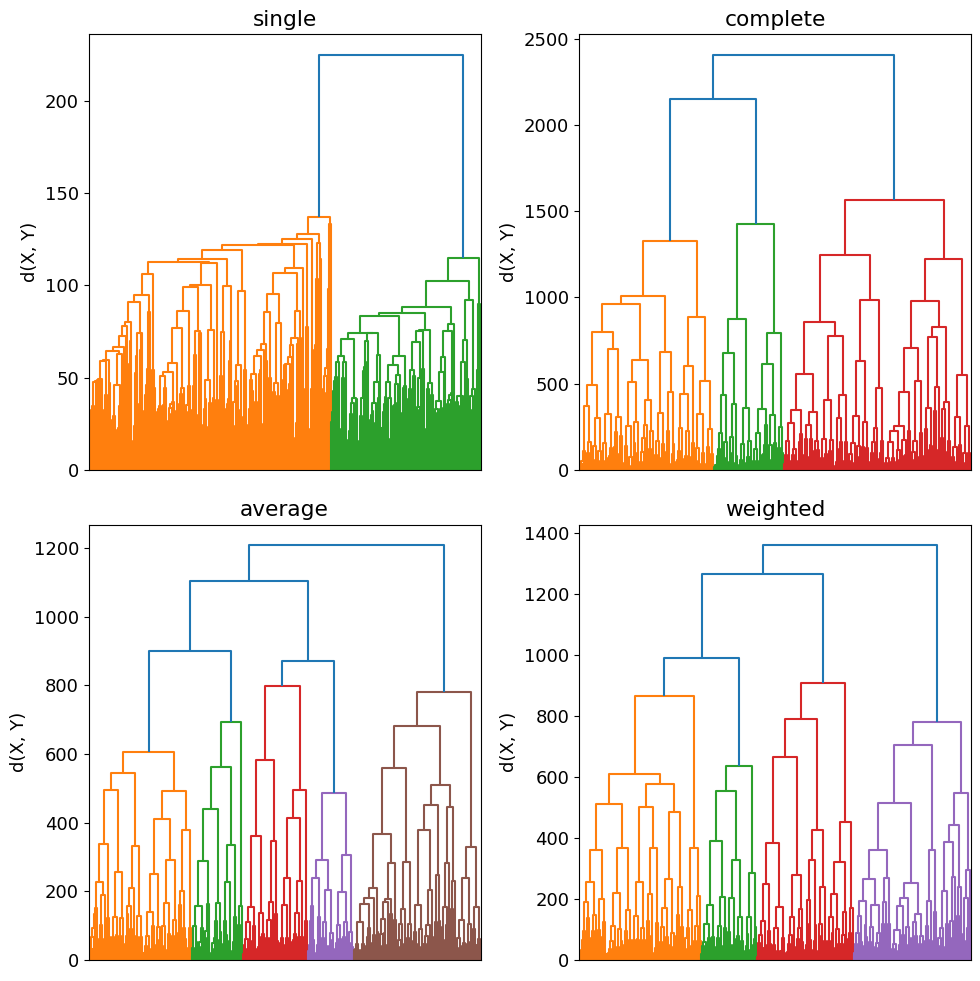

In [24]:
methods = ['single', 'complete', 'average', 'weighted']
z = [linkage(Xp.T, method = m, metric = 'euclidean', optimal_ordering = True) for m in methods]

fig, axs = plt.subplots(2, 2, figsize=(10,10))

# Hide axes for a cleaner look
for i, ax in enumerate(axs.flat):
    ax.set_title(methods[i])
    d = dendrogram(z[i], ax=ax, count_sort = 'descending', distance_sort =  'descending', 
             orientation = 'top', show_leaf_counts = False, leaf_rotation = 90 )
    ax.set_ylabel('d(X, Y)')
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

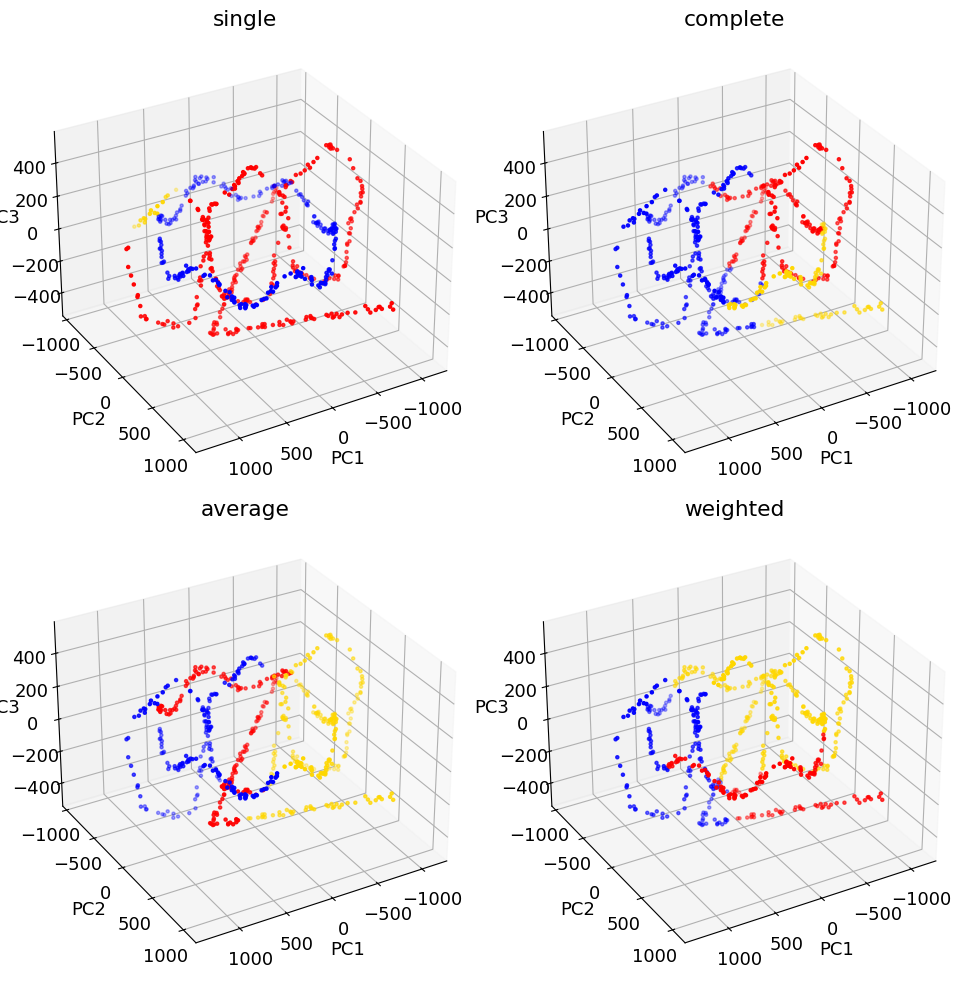

In [25]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'},figsize=(10,10))
nclusters=3
cluster_labels = [fcluster(Z, nclusters, criterion = 'maxclust') for Z in z]

for i, (ax, label) in enumerate(zip(axs.flat, cluster_labels)):
    ax.set_title(methods[i])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(30,60)

    # Plot points with clusters
    for cluster_num in range(1, nclusters + 1):
        cluster_points = Xp.T[label == cluster_num]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], marker = '.', color = colors[cluster_num-1])

plt.tight_layout()
plt.show()

In [26]:
for method, label in zip(methods, cluster_labels):
    print(f"NMI for method '{method}': {NMI(y_true, label):.2f}")

NMI for method 'single': 0.74
NMI for method 'complete': 0.10
NMI for method 'average': 0.16
NMI for method 'weighted': 0.09


We note that the 'single' method is by far the best one as it is capable of identifying correctly at least one of the clusters (the circular one). The remaining two clusters are unfortunately still indistinguishable.

### Section 4 (optional)

#### Experimenting with different transformations

In this section we perform a transformation of the data using different methods, in order to detect a linearly separable visualization.

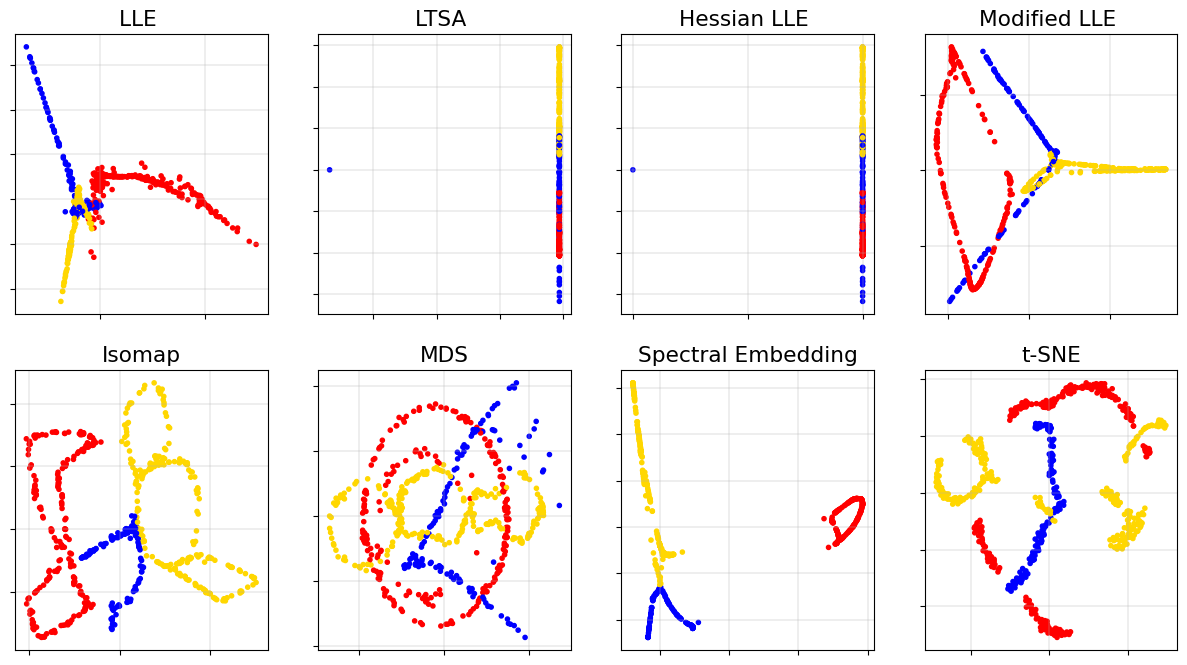

In [27]:
methods_of_visualization = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

n_neighbors = 10
manifolds = [manifold.Isomap(n_neighbors = n_neighbors, n_components = 2),
             manifold.MDS(2, max_iter = 100, n_init = 1, random_state = 42),
             manifold.SpectralEmbedding(n_components = 2, n_neighbors = n_neighbors, random_state = 42),
             manifold.TSNE(n_components = 2, random_state = 0)]
labels2 = ["Isomap", "MDS", "Spectral Embedding", "t-SNE"]

fig = plt.figure(figsize=(15, 8))

for i, method in enumerate(methods_of_visualization):
    trans_data = (manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method=method, random_state=42, eigen_solver='dense').fit_transform(x).T)

    ax = fig.add_subplot(241 + i)
    plt.scatter(trans_data[0], trans_data[1], c= yclusters_colors, marker = '.')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.title("%s " % (labels[i]))
    plt.grid(True, linewidth=0.3)
    plt.axis("tight")

for i, m in enumerate(manifolds):
    trans_data = m.fit_transform(x).T

    ax = fig.add_subplot(245 + i)
    plt.scatter(trans_data[0], trans_data[1], c = yclusters_colors, marker = '.')
    plt.title(labels2[i])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")
    plt.grid(True, linewidth=0.3)
    
plt.show()

It is possible to observe that, by applying Spectral Embedding and Isomap, the data clusters are more distanced. We can conclude that now it should be possible to apply the Kmeans algorithm and better detect the centroids, with respect to the previous case.

All the other transformations, in particular LTSA and Hessian LLE, are not suitable to our dataset.

#### Application of Kmeans to the transformed dataset

Spectral Embedding with kmeans is working well, detecting a label structure similar to the true labels. Contrarily, Isomap collects all data in only one cluster.

The NMI of Kmeans with isomap is: 0.35
The NMI of Kmeans with spectral embedding is: 0.73


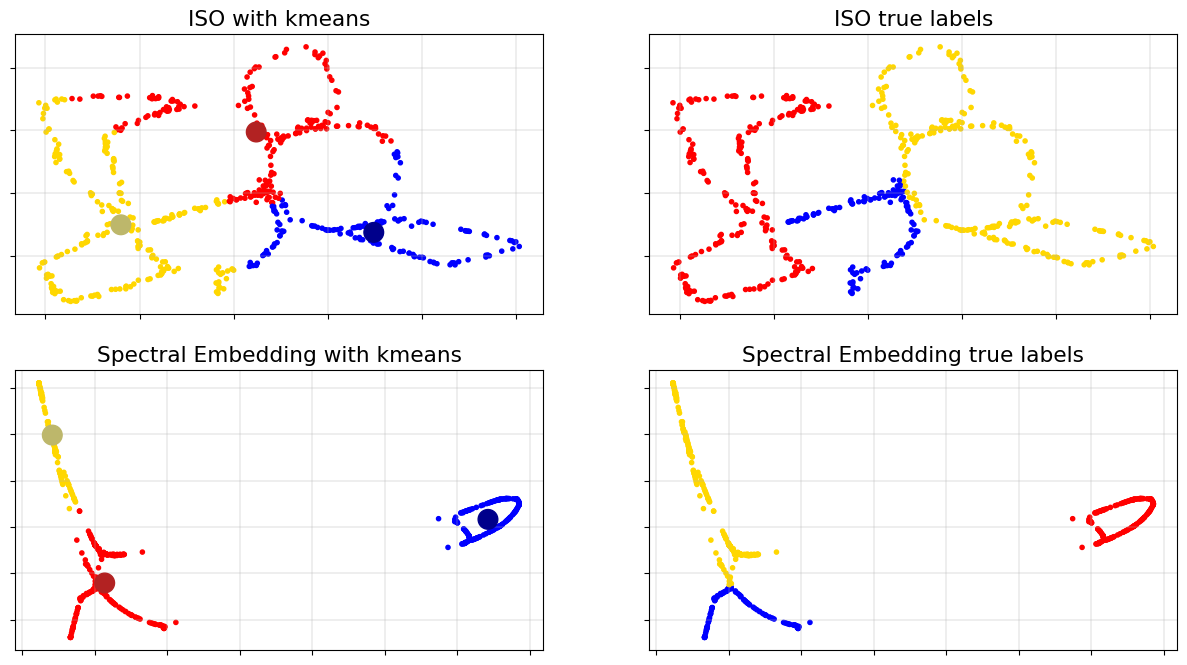

In [28]:
# Applying kmeans to Isomap
nclusters = 3

kmeans = KMeans(n_clusters=nclusters, init='random', n_init='auto', max_iter=50)

trans_data_iso = manifolds[0].fit_transform(x).T
kfit = kmeans.fit(trans_data_iso.T)
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_
kcentroids_colors = ['firebrick', 'darkkhaki', 'darkblue']
kclusters_colors = []

for i,k  in enumerate(kclusters):
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('gold')
    elif k == 2:
        kclusters_colors.append('blue')

print(f"The NMI of Kmeans with isomap is: {NMI(kclusters, y_true):.2f}")

fig = plt.figure(figsize=(15, 8))
        
ax = fig.add_subplot(221)
plt.scatter(trans_data_iso[0], trans_data_iso[1], c=kclusters_colors, marker = '.')
plt.title("ISO with kmeans")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.grid(True, linewidth=0.3)
kcentroids = kcentroids[:3, :2]
ax.scatter(kcentroids[:, 0], kcentroids[:,1], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

ax = fig.add_subplot(222)
plt.scatter(trans_data_iso[0], trans_data_iso[1], c=yclusters_colors, marker = '.')
plt.title("ISO true labels")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")
plt.grid(True, linewidth=0.3)

# Applying kmeans to Spectral Embedding 

trans_data_se = manifolds[2].fit_transform(x).T
kfit = kmeans.fit(trans_data_se.T)
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_
kcentroids_colors = ['firebrick', 'darkkhaki', 'darkblue']
kclusters_colors = []

for i,k  in enumerate(kclusters):
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('gold')
    elif k == 2:
        kclusters_colors.append('blue')

print(f"The NMI of Kmeans with spectral embedding is: {NMI(kclusters, y_true):.2f}")

ax = fig.add_subplot(223)
plt.scatter(trans_data_se[0], trans_data_se[1], c=kclusters_colors, marker = '.')
plt.title("Spectral Embedding with kmeans")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.grid(True, linewidth=0.3)
kcentroids = kcentroids[:3, :2]
ax.scatter(kcentroids[:, 0], kcentroids[:,1], s = 200, zorder=10, color = kcentroids_colors, alpha = 1)

ax = fig.add_subplot(224)
plt.scatter(trans_data_se[0], trans_data_se[1], c=yclusters_colors, marker = '.')
plt.title("Spectral Embedding true labels")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")
plt.grid(True, linewidth=0.3)

#### Application of Hierarchical clustering to the transformed dataset

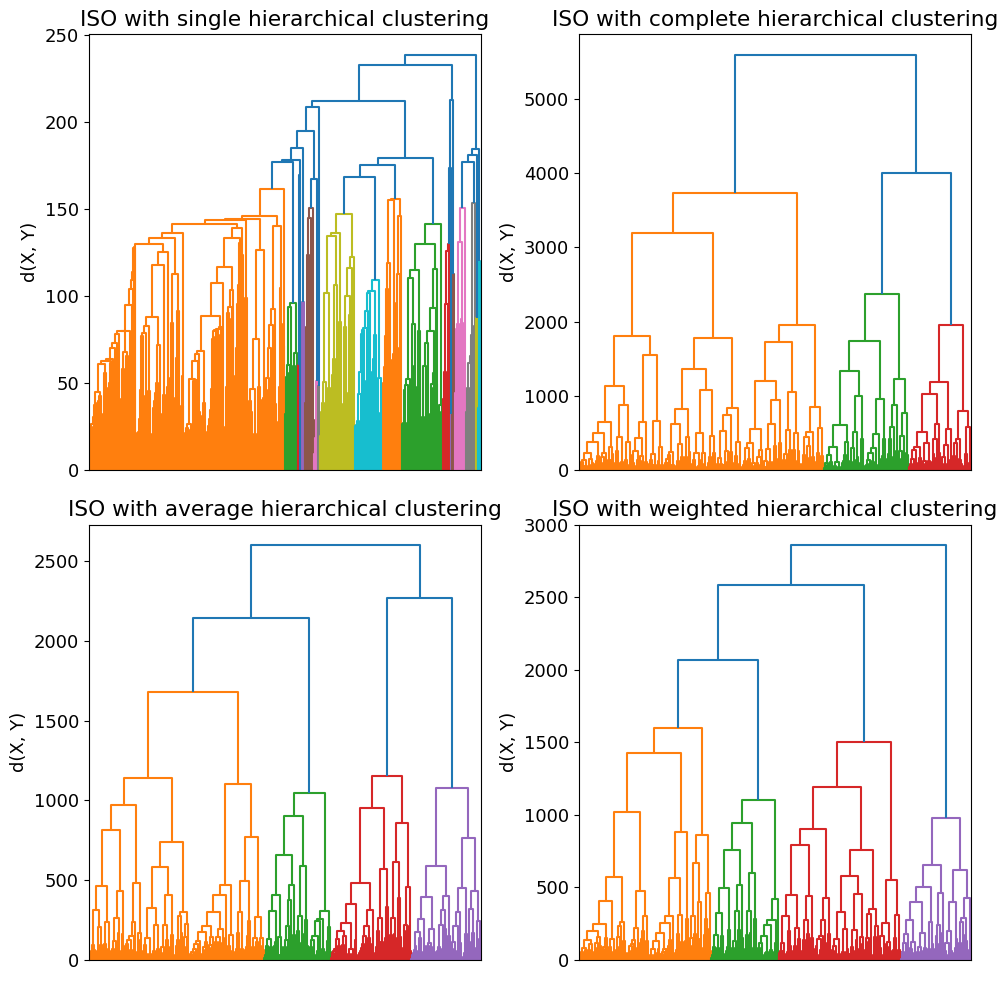

In [29]:
# Applying Isomap to hierarchical clustering
methods = ['single', 'complete', 'average', 'weighted']
z = [linkage(trans_data_iso.T, method = m, metric = 'euclidean', optimal_ordering = True) for m in methods]

fig, axs = plt.subplots(2, 2, figsize=(10,10))

# Hide axes for a cleaner look
for i, ax in enumerate(axs.flat):
    ax.set_title("ISO with " + methods[i] + " hierarchical clustering")
    d = dendrogram(z[i], ax=ax, count_sort = 'descending', distance_sort =  'descending', 
             orientation = 'top', show_leaf_counts = False, leaf_rotation = 90 )
    ax.set_ylabel('d(X, Y)')
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

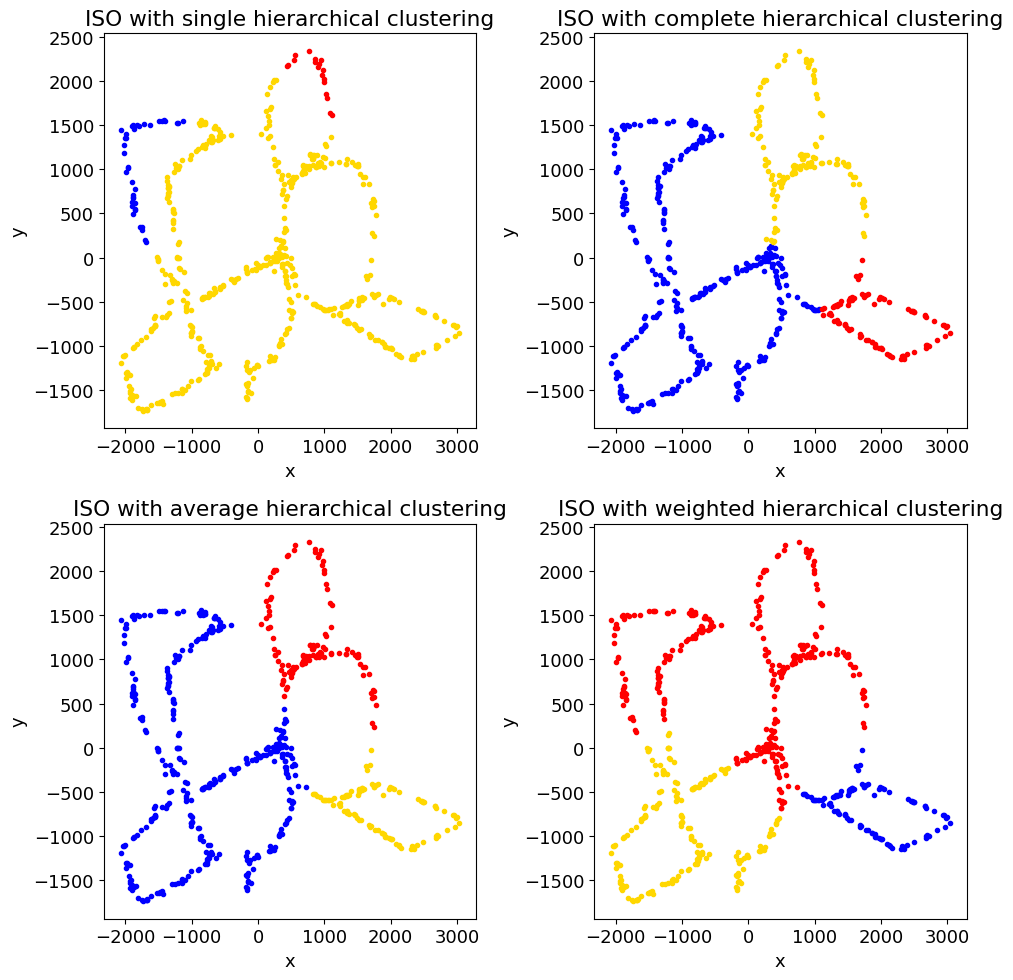

In [30]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
nclusters=3
cluster_labels = [fcluster(Z, nclusters, criterion = 'maxclust') for Z in z]

for i, (ax, label) in enumerate(zip(axs.flat, cluster_labels)):
    ax.set_title("ISO with " + methods[i] + " hierarchical clustering")

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Plot points with clusters
    for cluster_num in range(1, nclusters + 1):
        cluster_points = trans_data_iso.T[label == cluster_num]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], marker = '.', color = colors[cluster_num-1])

plt.tight_layout()
plt.show()

In [31]:
print("Applying the hierarchical clustering after an isomap transformation we obtain")
for method, label in zip(methods, cluster_labels):
    print(f"NMI for method '{method}': {NMI(y_true, label):.2f}")

Applying the hierarchical clustering after an isomap transformation we obtain
NMI for method 'single': 0.13
NMI for method 'complete': 0.53
NMI for method 'average': 0.56
NMI for method 'weighted': 0.32


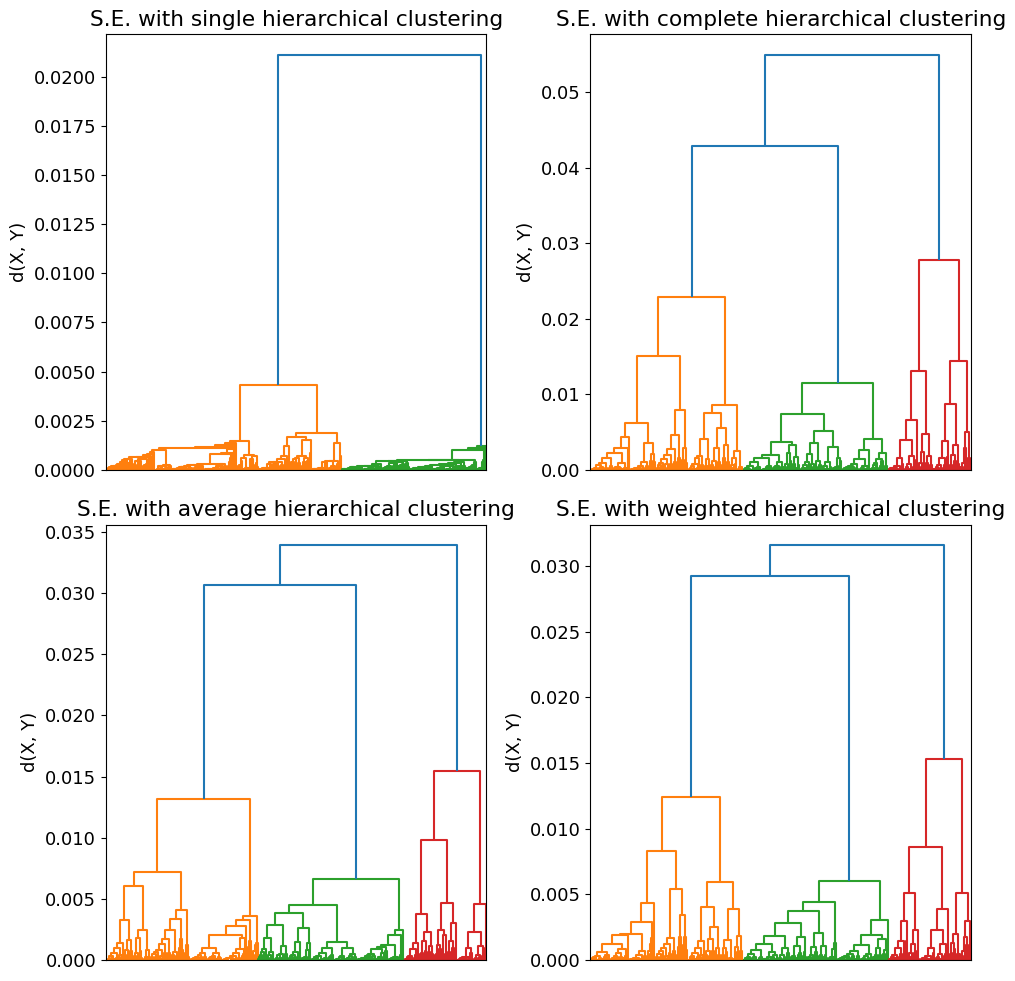

In [32]:
# Applying SE to hierarchical clustering
methods = ['single', 'complete', 'average', 'weighted']
z = [linkage(trans_data_se.T, method = m, metric = 'euclidean', optimal_ordering = True) for m in methods]

fig, axs = plt.subplots(2, 2, figsize=(10,10))

# Hide axes for a cleaner look
for i, ax in enumerate(axs.flat):
    ax.set_title("S.E. with " + methods[i] + " hierarchical clustering")
    d = dendrogram(z[i], ax=ax, count_sort = 'descending', distance_sort =  'descending', 
             orientation = 'top', show_leaf_counts = False, leaf_rotation = 90 )
    ax.set_ylabel('d(X, Y)')
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

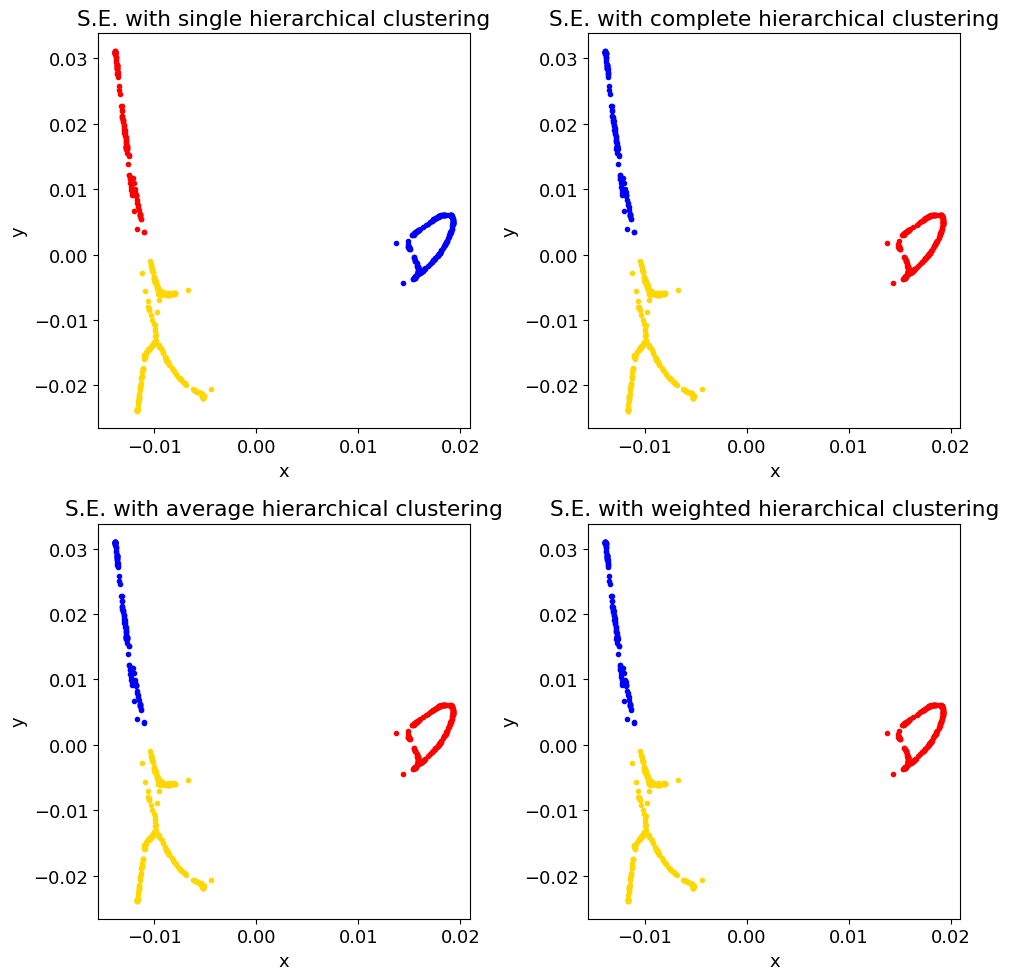

In [33]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
nclusters=3
cluster_labels = [fcluster(Z, nclusters, criterion = 'maxclust') for Z in z]

for i, (ax, label) in enumerate(zip(axs.flat, cluster_labels)):
    ax.set_title("S.E. with " + methods[i] + " hierarchical clustering")

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Plot points with clusters
    for cluster_num in range(1, nclusters + 1):
        cluster_points = trans_data_se.T[label == cluster_num]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], marker = '.', color = colors[cluster_num-1])

plt.tight_layout()
plt.show()

In [34]:
print("Applying the hierarchical clustering after a spectral embedding transformation we obtain")
for method, label in zip(methods, cluster_labels):
    print(f"NMI for method '{method}': {NMI(y_true, label):.2f}")

Applying the hierarchical clustering after a spectral embedding transformation we obtain
NMI for method 'single': 0.74
NMI for method 'complete': 0.74
NMI for method 'average': 0.74
NMI for method 'weighted': 0.74
